In [5]:
import re
from dataclasses import dataclass
from typing import List, Optional, Any, Dict, Tuple

## Lexer

In [6]:
TokenSpec = [
    ("NUMBER",      r"\d+"),
    ("NOTE",        r"[A-G](?:#|b)?\d"),        # e.g., C4, F#3, Bb5
    ("DURATION",    r"whole|half|quarter|eighth|sixteenth"), # common durations
    ("SET",         r"Set\b|set\b"),
    ("KEY",         r"key\b|Key\b"),
    ("TIME",        r"time\b|Time\b"),
    ("SIGNATURE",   r"signature\b|Signature\b"),
    ("TEMPO",       r"tempo\b|Tempo\b"),
    ("VOICE",       r"Voice\b|voice\b"),
    ("REST",        r"Rest\b|rest\b"),           # For rest notation
    ("IN",          r"In\b|in\b"),
    ("MEASURE",     r"measure\b|Measure\b"),
    ("TO",          r"to\b|To\b"),
    ("COLON",       r":"),
    ("COMMA",       r","),
    ("SLASH",       r"/"),
    ("DOT",         r"\."),                     # For dotted durations
    ("LBRACKET",    r"\["),                     # For chord notation
    ("RBRACKET",    r"\]"),                     # For chord notation
    ("IDENT",       r"[A-Za-z+#]+"),            # words like 'C', 'major', 'minor'
    ("NEWLINE",     r"\n"),
    ("WS",          r"[ \t]+"),
    ("UNKNOWN",     r"."),
]
tok_regex = "|".join(f"(?P<{name}>{pattern})" for name, pattern in TokenSpec)

@dataclass
class Token:
    type: str
    value: str
    pos: int

In [7]:
class Lexer:
    def __init__(self, text: str):
        self.text = text
        self.pos = 0
        self.tokens: List[Token] = []

    def tokenize(self) -> List[Token]:
        for m in re.finditer(tok_regex, self.text):
            kind = m.lastgroup
            value = m.group()
            pos = m.start()
            if kind == "WS" or kind == "NEWLINE":
                continue
            if kind == "UNKNOWN":
                raise SyntaxError(f"Unknown token {value!r} at pos {pos}")
 
            tok = Token(kind, value, pos)
            self.tokens.append(tok)
        self.tokens.append(Token("EOF", "", len(self.text)))
        return self.tokens

### Testing tokens

In [6]:
sample = """
Set key to G major
Set time signature to 3/4

In measure 1:
        G4 quarter., B4 quarter, A4 sixteenth.
In measure 2:
        C5 half, Rest quarter
"""
lexer = Lexer(sample.strip())
tokens = lexer.tokenize()
for token in tokens:
    print(token)

Token(type='SET', value='Set', pos=0)
Token(type='KEY', value='key', pos=4)
Token(type='TO', value='to', pos=8)
Token(type='IDENT', value='G', pos=11)
Token(type='IDENT', value='major', pos=13)
Token(type='SET', value='Set', pos=19)
Token(type='TIME', value='time', pos=23)
Token(type='SIGNATURE', value='signature', pos=28)
Token(type='TO', value='to', pos=38)
Token(type='NUMBER', value='3', pos=41)
Token(type='SLASH', value='/', pos=42)
Token(type='NUMBER', value='4', pos=43)
Token(type='IN', value='In', pos=46)
Token(type='MEASURE', value='measure', pos=49)
Token(type='NUMBER', value='1', pos=57)
Token(type='COLON', value=':', pos=58)
Token(type='NOTE', value='G4', pos=68)
Token(type='DURATION', value='quarter', pos=71)
Token(type='DOT', value='.', pos=78)
Token(type='COMMA', value=',', pos=79)
Token(type='NOTE', value='B4', pos=81)
Token(type='DURATION', value='quarter', pos=84)
Token(type='COMMA', value=',', pos=91)
Token(type='NOTE', value='A4', pos=93)
Token(type='DURATION', value

## Parser

In [8]:
class Parser:
    def __init__(self, tokens):
        self.tokens = tokens
        self.pos = 0

    def peek(self):
        if self.pos < len(self.tokens):
            return self.tokens[self.pos]
        return None
    
    def eat(self, expected_type=None):
        token = self.peek()
        if token is None:
            raise SyntaxError("Unexpected end of input")    
        if expected_type and token.type != expected_type:
            raise SyntaxError(f"Expected token type {expected_type}, got {token.type}")
        self.pos += 1
        return token
    
    def parse_list(self):
        statements = []
        while self.peek().type != "EOF":
            statements.append(self.parse_statement())
        return ("list", statements)
    
    def parse_statement(self):
        token = self.peek()
        if token.type == "SET":
            self.eat("SET")
            next_tok = self.peek()
            if next_tok.type == "KEY":
                return self.parse_set_key_stmt()
            elif next_tok.type == "TIME":
                return self.parse_set_time_signature_stmt()
            elif next_tok.type == "TEMPO":
                return self.parse_set_tempo_stmt()
            else:
                raise SyntaxError(f"Unexpected token {next_tok.type} after SET")
        
        elif token.type == "VOICE":
            return self.parse_voice_stmt()
        
        elif token.type == "IN":
            self.eat("IN")
            return self.parse_measure_stmt()
        else:
            raise SyntaxError(f"Unexpected statement start: {token.type}")
        
    def parse_set_key_stmt(self):
        self.eat("KEY")
        self.eat("TO")
        key_name = self.eat("IDENT").value
        mode = self.eat("IDENT").value
        return ("set_key", key_name, mode)
    
    def parse_set_time_signature_stmt(self):
        self.eat("TIME")
        self.eat("SIGNATURE")
        self.eat("TO")
        numerator = int(self.eat("NUMBER").value)
        self.eat("SLASH")
        denominator = int(self.eat("NUMBER").value)
        return ("set_time_signature", numerator, denominator)
    
    def parse_set_tempo_stmt(self):
        self.eat("TEMPO")
        self.eat("TO")
        bpm = int(self.eat("NUMBER").value)
        return ("set_tempo", bpm)

    def parse_voice_stmt(self):
        self.eat("VOICE")
        voice_num = int(self.eat("NUMBER").value)
        self.eat("COLON")
        measures = []
        
        # Parse all measures in this voice
        while self.peek() and self.peek().type == "IN":
            self.eat("IN")
            measures.append(self.parse_measure_stmt_content())
        
        return ("voice", voice_num, measures)

    def parse_measure_stmt(self):
        # For backward compatibility with old syntax
        measure_data = self.parse_measure_stmt_content()
        return ("measure", measure_data[1], measure_data[2])

    def parse_measure_stmt_content(self):
        self.eat("MEASURE")
        measure_num = int(self.eat("NUMBER").value)
        self.eat("COLON")
        notes = []
        self.parse_note_list(notes)
        return ("measure", measure_num, notes)      
    
    def parse_note_list(self, notes):
        notes.append(self.parse_note_entry())
        while self.peek() and self.peek().type == "COMMA":
            self.eat("COMMA")
            # Check if next token starts a new measure or voice
            if self.peek() and self.peek().type in ["IN", "VOICE"]:
                break
            notes.append(self.parse_note_entry())
        return notes
    
    def parse_note_entry(self):
        # Check if this is a chord (starts with '[')
        if self.peek() and self.peek().type == "LBRACKET":
            return self.parse_chord_entry()
        # Check if this is a rest
        elif self.peek() and self.peek().type == "REST":
            return self.parse_rest_entry()
        else:
            # Single note
            note = self.eat("NOTE").value
            duration = self.eat("DURATION").value
            # Check for optional dot
            if self.peek() and self.peek().type == "DOT":
                self.eat("DOT")
                duration += "."  # Add dot to duration string
            return ("note", note, duration)
    
    def parse_rest_entry(self):
        self.eat("REST")
        duration = self.eat("DURATION").value
        # Check for optional dot
        if self.peek() and self.peek().type == "DOT":
            self.eat("DOT")
            duration += "."  # Add dot to duration string
        return ("rest", duration)
    
    def parse_chord_entry(self):
        self.eat("LBRACKET")
        note_names = []
        
        # Parse first note
        note_names.append(self.eat("NOTE").value)
        
        # Parse additional notes separated by commas
        while self.peek() and self.peek().type == "COMMA":
            self.eat("COMMA")
            if self.peek() and self.peek().type == "NOTE":
                note_names.append(self.eat("NOTE").value)
        
        self.eat("RBRACKET")
        
        # Get the duration for the entire chord
        if self.peek() and self.peek().type == "DURATION":
            duration = self.eat("DURATION").value
            # Check for optional dot
            if self.peek() and self.peek().type == "DOT":
                self.eat("DOT")
                duration += "."  # Add dot to duration string
        else:
            raise SyntaxError("Chord must have a duration specified")
        
        return ("chord", note_names, duration)

In [8]:
parser = Parser(tokens)
ast = parser.parse_list()
print(ast)

('list', [('set_key', 'G', 'major'), ('set_time_signature', 3, 4), ('measure', 1, [('note', 'G4', 'quarter.'), ('note', 'B4', 'quarter'), ('note', 'A4', 'sixteenth.')]), ('measure', 2, [('note', 'C5', 'half'), ('rest', 'quarter')])])


## Semantic Analyzer

In [9]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'

UserSettingsException: attempting to set a value to a path that does not exist: /home/yuan/Documents/projects/python/ppl/sheetmusicnotation/C:/Program Files/MuseScore 4/bin/MuseScore4.exe

In [9]:
# For Linux
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore3/mscore'
us['musicxmlPath'] = '/usr/bin/mscore3/mscore'

In [10]:
class Semantic_Analyzer:
    def __init__(self, ast):
        self.ast = ast
        self.key = None
        self.time_signature = None
        self.tempo = None
        self.voices = {}  # Dictionary to store measures for each voice

        self.score = stream.Score()
        
    def analyze(self):
        if self.ast[0] != "list":
            raise ValueError("AST must be a list of statements")
        
        # First pass: collect global settings and voice data
        for stmt in self.ast[1]:
            if stmt[0] in ["set_key", "set_time_signature", "set_tempo"]:
                self.analyze_global_statement(stmt)
            elif stmt[0] == "voice":
                self.analyze_voice_statement(stmt)
            elif stmt[0] == "measure":
                # Handle old syntax - treat as voice 1
                if 1 not in self.voices:
                    self.voices[1] = []
                self.voices[1].append(stmt)
        
        # Second pass: create parts for each voice
        for voice_num in sorted(self.voices.keys()):
            part = stream.Part()
            part.partName = f"Voice {voice_num}"
            
            # Add global settings to each part
            if self.key:
                part.append(key.Key(self.key[0], self.key[1]))
            if self.time_signature:
                part.append(meter.TimeSignature(f"{self.time_signature[0]}/{self.time_signature[1]}"))
            if self.tempo:
                part.append(tempo.MetronomeMark(number=self.tempo))
            
            # Add measures for this voice
            for measure_stmt in self.voices[voice_num]:
                self.add_measure_to_part(part, measure_stmt)
            
            self.score.append(part)
        
        # Generate output
        self.score.write('musicxml', fp='output.xml')
        self.score.show('midi')
        self.score.show()
    
    def analyze_global_statement(self, stmt):
        if stmt[0] == "set_key":
            _, key_name, mode = stmt
            self.key = (key_name, mode)
        
        elif stmt[0] == "set_time_signature":
            _, numerator, denominator = stmt
            self.time_signature = (numerator, denominator)
        
        elif stmt[0] == "set_tempo":
            _, bpm = stmt
            self.tempo = bpm
    
    def analyze_voice_statement(self, stmt):
        _, voice_num, measures = stmt
        if voice_num not in self.voices:
            self.voices[voice_num] = []
        self.voices[voice_num].extend(measures)
    
    def add_measure_to_part(self, part, measure_stmt):
        if measure_stmt[0] == "measure":
            _, measure_num, notes = measure_stmt
        else:
            # It's already parsed measure content
            measure_num, notes = measure_stmt[1], measure_stmt[2]
        
        m = stream.Measure(number=measure_num)
        
        for note_entry in notes:
            if note_entry[0] == "note":
                _, pitch, dur = note_entry

                
                n = note.Note(pitch)
                # Handle dotted durations
                if dur.endswith("."):
                    base_dur = dur[:-1]  # Remove the dot
                    if base_dur == "sixteenth":
                        base_dur = "16th"
                    n.duration.type = base_dur
                    n.duration.dots = 1
                else:
                    n.duration.type = dur
                m.append(n)
            
            elif note_entry[0] == "chord":
                _, pitches, dur = note_entry
                # Convert "sixteenth" to "16th" for music21 compatibility
                if dur == "sixteenth":
                    dur = "16th"
                elif dur == "sixteenth.":
                    dur = "16th"
                
                c = chord.Chord(pitches)
                # Handle dotted durations
                if dur.endswith("."):
                    base_dur = dur[:-1]  # Remove the dot
                    if base_dur == "sixteenth":
                        base_dur = "16th"
                    c.duration.type = base_dur
                    c.duration.dots = 1
                else:
                    c.duration.type = dur
                m.append(c)
            
            elif note_entry[0] == "rest":
                _, dur = note_entry
                # Convert "sixteenth" to "16th" for music21 compatibility
                if dur == "sixteenth":
                    dur = "16th"
                elif dur == "sixteenth.":
                    dur = "16th"
                
                r = note.Rest()
                # Handle dotted durations
                if dur.endswith("."):
                    base_dur = dur[:-1]  # Remove the dot
                    if base_dur == "sixteenth":
                        base_dur = "16th"
                    r.duration.type = base_dur
                    r.duration.dots = 1
                else:
                    r.duration.type = dur
                m.append(r)
        
        part.append(m)

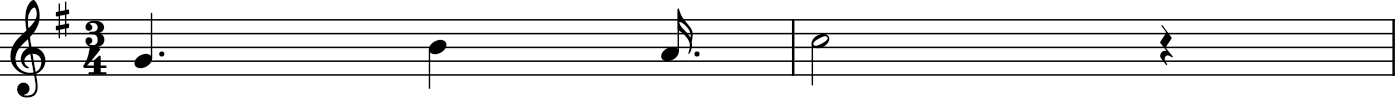

In [ ]:
interpreter = Semantic_Analyzer(ast)
interpreter.analyze()

## Full demonstration

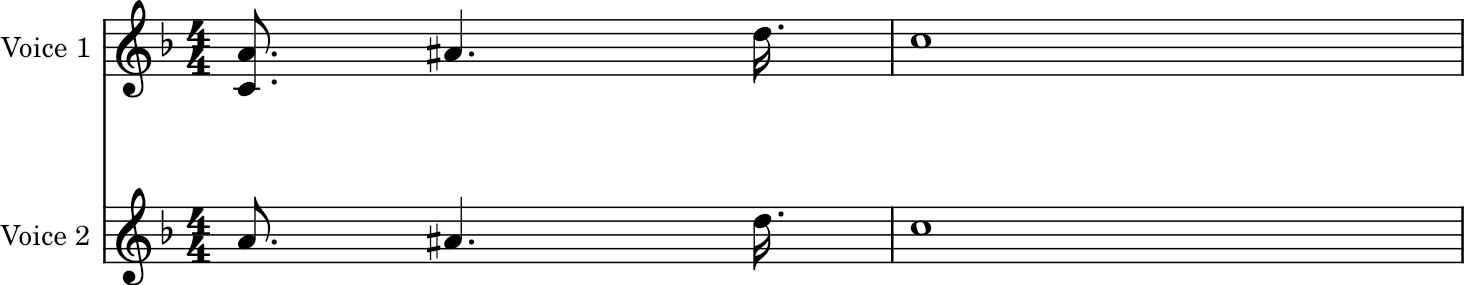

In [28]:
chorus_section = """
Set key to F major
Set time signature to 4/4
Set tempo to 200

Voice 1:
    In measure 1:
        [A4, C4] eighth., A#4 quarter., D5 sixteenth.
    In measure 2:
        C5 whole
        
Voice 2:
    In measure 1:
        A4 eighth., A#4 quarter., D5 sixteenth.
    In measure 2:
        C5 whole

"""

fulldemo_interpreter = Semantic_Analyzer(Parser(Lexer(chorus_section.strip()).tokenize()).parse_list())
fulldemo_interpreter.analyze()

In [11]:
# Rendering helpers: render_score_to_png_bytes and display_png_from_text
import tempfile
from IPython.display import Image, clear_output, display

def render_score_to_png_bytes(text: str) -> bytes:
    """Parse the notation text and return PNG bytes using music21 + MuseScore."""
    # Parse
    lexer = Lexer(text.strip())
    tokens = lexer.tokenize()
    parser = Parser(tokens)
    ast = parser.parse_list()
    analyzer = Semantic_Analyzer(ast)
    # Build score (this may call analyzer.analyze() which in this notebook also writes/shows;
    # we call analyze() to ensure parts are constructed)
    try:
        analyzer.analyze()
    except Exception:
        # If analyze tries to show and fails, we still have analyzer.score populated in many cases
        pass
    # Write to temporary PNG
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tf:
        png_path = tf.name
    try:
        analyzer.score.write('musicxml.png', fp=png_path)
    except Exception:
        try:
            analyzer.score.show('musicxml.png')
        except Exception as e:
            raise RuntimeError(f"Could not generate PNG: {e}")
    with open(png_path, 'rb') as f:
        data = f.read()
    return data


def display_png_from_text(text: str):
    """Render text and display PNG inline (clears previous output).
    This is used by the fallback UI.`"""
    try:
        png = render_score_to_png_bytes(text)
        clear_output(wait=True)
        display(Image(data=png))
    except Exception as e:
        clear_output(wait=True)
        print('Render error:', e)


In [12]:
# Line-based UI helpers for the notebook
# Usage: add_line_and_render('Set key to C major') or via the UI below
notation_lines = []

from IPython.display import display, Image, clear_output

def _render_text_and_display(text:
    str):
    """Internal helper: try to use display_png_from_text if available,
    otherwise use render_score_to_png_bytes (both may be defined elsewhere in notebook)."""
    try:
        # Prefer the helper if present
        display_png_from_text(text)
    except NameError:
        # Fallback: try to render directly
        try:
            png = render_score_to_png_bytes(text)
            clear_output(wait=True)
            display(Image(data=png))
        except NameError as e:
            # Neither helper is available
            clear_output(wait=True)
            print('Render helpers not found in notebook. Define render_score_to_png_bytes or display_png_from_text.')
            print('Error:', e)


def add_line_and_render(line: str):
    """Append a line to the in-memory notation buffer and render the full notation."""
    global notation_lines
    notation_lines.append(line)
    text = "\n".join(notation_lines)
    print(f"Appending line: {line}")
    _render_text_and_display(text)


def clear_notation():
    global notation_lines
    notation_lines = []
    clear_output(wait=True)
    print('Notation cleared. Enter new lines using the UI.')


def show_notation():
    print('Current notation (joined lines):')
    print('\n'.join(notation_lines))


In [20]:
# Pure Python UI using ipywidgets - no JavaScript needed!
import ipywidgets as widgets
from IPython.display import display, clear_output

# Global buffer
notation_lines = []

# Output area for the rendered sheet music
output_area = widgets.Output()

# Text input widget
text_input = widgets.Text(
    placeholder='Type a line and press Enter',
    description='Line:',
    layout=widgets.Layout(width='600px')
)

# Buttons
add_button = widgets.Button(
    description='Add Line',
    button_style='success',
    icon='plus'
)

clear_button = widgets.Button(
    description='Clear All',
    button_style='warning',
    icon='trash'
)

show_buffer_button = widgets.Button(
    description='Show Buffer',
    button_style='info',
    icon='eye'
)

# Status label
status_label = widgets.HTML(value='<i>Ready. Enter a notation line above.</i>')

def render_current_notation():
    """Render all accumulated notation lines."""
    if not notation_lines:
        with output_area:
            clear_output(wait=True)
            print("No notation entered yet.")
        return
    
    text = "\n".join(notation_lines)
    with output_area:
        clear_output(wait=True)
        try:
            png = render_score_to_png_bytes(text)
            display(Image(data=png))
        except Exception as e:
            print(f"Render error: {e}")

def on_add_line(b=None):
    """Add the current line to the buffer and render."""
    line = text_input.value.strip()
    if not line:
        status_label.value = '<span style="color:orange;">Please enter a line first.</span>'
        return
    
    notation_lines.append(line)
    status_label.value = f'<span style="color:green;">Added: {line}</span>'
    text_input.value = ''  # Clear input
    render_current_notation()

def on_clear(b):
    """Clear all notation."""
    global notation_lines
    notation_lines = []
    with output_area:
        clear_output(wait=True)
        print("Notation cleared.")
    status_label.value = '<span style="color:blue;">Cleared all notation.</span>'

def on_show_buffer(b):
    """Show the current buffer contents."""
    with output_area:
        clear_output(wait=True)
        if notation_lines:
            print("Current notation buffer:")
            print("-" * 40)
            for i, line in enumerate(notation_lines, 1):
                print(f"{i}. {line}")
        else:
            print("Buffer is empty.")

def on_text_submit(sender):
    """Called when user presses Enter in the text field."""
    on_add_line()

# Wire up event handlers
add_button.on_click(on_add_line)
clear_button.on_click(on_clear)
show_buffer_button.on_click(on_show_buffer)
text_input.on_submit(on_text_submit)

# Build the UI layout
button_row = widgets.HBox([add_button, clear_button, show_buffer_button])
ui = widgets.VBox([
    widgets.HTML('<h3>Sheet Music Notation Interpreter</h3>'),
    text_input,
    button_row,
    status_label,
    output_area
])

# Display the UI
display(ui)


/tmp/ipykernel_7215/85074528.py:98: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_input.on_submit(on_text_submit)
